In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import json
import torch
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from nerfstudio.utils.eval_utils import eval_setup
from plane_nerf.inerf_trainer import load_data_into_trainer
from plane_nerf.inerf_utils import get_corrected_pose, load_eval_image_into_pipeline, get_relative_pose, get_absolute_diff_for_pose, get_image

/home/user/.local/lib/python3.10/site-packages/tinycudann/modules.py:31: UserWarning: System has multiple GPUs with different compute capabilities: [61, 52]. Using compute capability 52 for best compatibility. This may result in suboptimal performance.
  warnings.warn(


In [ ]:
os.chdir('/workspace/plane-nerf/')
MODEL_PATH = "/workspace/plane-nerf/outputs/jackal_floor_training_data_1/plane-nerf/2024-03-11_145657"
DATA_PATH = "/workspace/plane-nerf/data/jackal_one_frame_floor"
TRANSFORM_FILE = "transforms.json"
with open(os.path.join(DATA_PATH, "ground_truth.json")) as f:
    GROUND_TRUTH = json.load(f)
with open(os.path.join(DATA_PATH, TRANSFORM_FILE)) as f:
    TRANSFORM = json.load(f)

In [ ]:
config_path = os.path.join(MODEL_PATH, "config.yml")
config, pipeline, _, _ = eval_setup(
                        Path(config_path),
                        test_mode="inference",
                    )

pipeline = load_eval_image_into_pipeline(pipeline,DATA_PATH,TRANSFORM)

config.pipeline.datamanager.pixel_sampler.num_rays_per_batch = 4096 

trainer = load_data_into_trainer(
    config,
    pipeline,
    plane_optimizer = True
)

trainer.pipeline.datamanager.KERNEL_SIZE = 5
trainer.pipeline.datamanager.THRESHOLD = 40
trainer.pipeline.datamanager.METHOD = "sift"

trainer.pipeline.datamanager.get_inerf_batch()  
trainer.pipeline.datamanager.inerf_batch["image"] = trainer.pipeline.datamanager.inerf_batch["image"].to(trainer.pipeline.device)
trainer.pipeline.train()


tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Falling back to CutlassMLP. For maximum performance, raise the target GPU architecture to 75+.
tiny-cuda-nn warning: FullyFusedMLP is not supported for the selected architecture 52. Fal

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf/2024-03-11_145657/nerfstudio_models/step-000009999.ckpt

Setting up training dataset...

Caching all 1 images.

Loading PlaneNerfCameraOptimizer


[13:18:05] Saving checkpoints to:                                                                         ]8;id=551939;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py\trainer.py]8;;\:]8;id=930477;file:///home/user/nerfstudio/nerfstudio/engine/trainer.py#136\136]8;;\
           outputs/jackal_floor_training_data_1/plane-nerf/2024-03-11_145657/nerfstudio_models                          

Loading latest Nerfstudio checkpoint from load_dir...


Done loading Nerfstudio checkpoint from 
outputs/jackal_floor_training_data_1/plane-nerf/2024-03-11_145657/nerfstudio_models/step-000009999.ckpt

Number of keypoints:  116
Number of rays:  5092
Reduce the number of rays
Final number of rays:  4096


PlaneNerfPipeline(
  (datamanager): PlaneNerfDataManager(
    (train_ray_generator): RayGenerator()
  )
  (_model): PlaneNerfModel(
    (collider): NearFarCollider()
    (field): PlaneNerfField(
      (spatial_distortion): SceneContraction()
      (embedding_appearance): Embedding(
        (embedding): Embedding(300, 32)
      )
      (direction_encoding): SHEncoding(
        (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=16, seed=1337, dtype=torch.float32, hyperparams={'degree': 4, 'otype': 'SphericalHarmonics'})
      )
      (position_encoding): NeRFEncoding(
        (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=12, seed=1337, dtype=torch.float32, hyperparams={'n_frequencies': 2, 'otype': 'Frequency'})
      )
      (mlp_base_grid): HashEncoding(
        (tcnn_encoding): Encoding(n_input_dims=3, n_output_dims=32, seed=1337, dtype=torch.float32, hyperparams={'base_resolution': 16, 'hash': 'CoherentPrime', 'interpolation': 'Linear', 'log2_hashmap_size': 19, 'n_featu

In [ ]:
ground_truth_poses = []
for _ , batch in pipeline.datamanager.fixed_indices_train_dataloader:
    tf = GROUND_TRUTH["frames"][int(batch['image_idx'])]["transform_matrix"]
    tf = np.asarray(tf)
    tf = tf[:3, :4 ]
    ground_truth_poses.append(tf)
ground_truth_poses = torch.tensor(ground_truth_poses).to(pipeline.device)

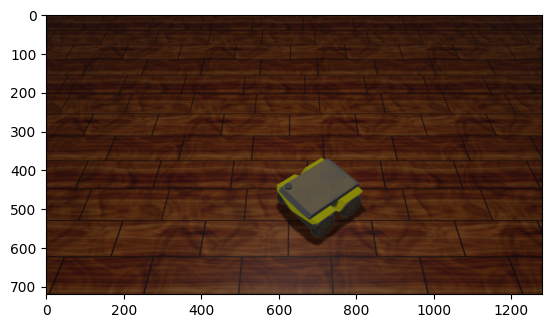

In [ ]:
original_img = cv2.imread(os.path.join(DATA_PATH, GROUND_TRUTH["frames"][0]["file_path"]))
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.imshow(original_img)

In [ ]:
ITERATION = 50
FRAMES = 1
LR = 1e-2
store = torch.tensor([])
imgs = []

from nerfstudio.data.dataparsers.base_dataparser import transform_poses_to_original_space
original_camera_pose = trainer.pipeline.datamanager.train_dataparser_outputs.cameras.camera_to_worlds.to("cuda:0")
original_camera_pose = transform_poses_to_original_space(
    original_camera_pose,
    trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_transform.to(trainer.pipeline.device),
    trainer.pipeline.datamanager.train_dataparser_outputs.dataparser_scale,
    "opengl"
)
print(original_camera_pose)

corrected_pose = get_corrected_pose(trainer)
#print(corrected_pose)
relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)
#Get averrage absolute translation and rotation error
print("Average translation error: ", torch.mean(t_diff))
print("Average rotation error: ", torch.mean(r_diff))
rendered_img = get_image(trainer.pipeline, original_camera_pose.float()) #Vital note render with original camera pose
imgs.append(rendered_img["rgb"].detach().cpu().numpy())

store = torch.cat((store, torch.tensor([[0, torch.mean(t_diff), torch.mean(r_diff)]])), 0)

for i in range(ITERATION):
    lr = LR * 0.8 ** (i / 100)
    loss = trainer.train_iteration_inerf(optimizer_lr=lr)
    corrected_pose = get_corrected_pose(trainer)
    #print(corrected_pose)
    relative_pose = get_relative_pose(ground_truth_poses, corrected_pose)
    t_diff, r_diff = get_absolute_diff_for_pose(relative_pose)

    #Get averrage absolute translation and rotation error
    print("Average translation error: ", torch.mean(t_diff))
    print("Average rotation error: ", torch.mean(r_diff))
    print(loss)
    
    store = torch.cat((store, torch.tensor([[i+1, torch.mean(t_diff), torch.mean(r_diff)]])), 0)

    if (i%FRAMES == FRAMES-1):
        rendered_img = get_image(trainer.pipeline, original_camera_pose.float()) #Vital note render with original camera pose
        imgs.append(rendered_img["rgb"].detach().cpu().numpy())

tensor([[[ 6.4945e-01,  5.3790e-01, -5.3748e-01, -1.6933e+00],
         [-7.6041e-01,  4.5941e-01, -4.5904e-01, -1.2547e+00],
         [-1.0302e-10,  7.0683e-01,  7.0739e-01,  2.5000e+00]]],
       device='cuda:0')
Average translation error:  tensor(0.0093, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
Average rotation error:  tensor(0.1338, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
import cv2
from PIL import Image

cv2_images = [(img * 0.5 + original_img/255 * 0.5) for img in imgs]
H,W,_ = cv2_images[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
out = cv2.VideoWriter('output_video.mp4', fourcc, 10.0, (W, H))
for i in range(len(cv2_images)):
    #min_pil = cv2_images[i].min()
    #max_pil = cv2_images[i].max()
    #cv2_images[i] = (cv2_images[i] - min_pil) / (max_pil - min_pil)
    cv2_images[i] = (cv2_images[i] * 255).astype(np.uint8)
    cv2_images[i] = cv2.cvtColor(cv2_images[i], cv2.COLOR_RGB2BGR)
    out.write(cv2_images[i])
out.release()

In [ ]:
if False:
    #Stack cv2 images side by side in a single image

    PIL_images = [Image.fromarray(cv2.cvtColor(cv2_images[i], cv2.COLOR_BGR2RGB)) for i in range(len(cv2_images))]
    side_by_side = Image.new('RGB', (W*len(PIL_images), H))
    x_offset = 0
    for im in PIL_images:
        side_by_side.paste(im, (x_offset,0))
        x_offset += W

    side_by_side.save("output_image.png")

